<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Framing-Time-Series-As-Supervised-Learning-Problem" data-toc-modified-id="Framing-Time-Series-As-Supervised-Learning-Problem-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Framing Time Series As Supervised Learning Problem</a></span><ul class="toc-item"><li><span><a href="#Lag-Features" data-toc-modified-id="Lag-Features-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Lag Features</a></span></li><li><span><a href="#Window-Features" data-toc-modified-id="Window-Features-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Window Features</a></span></li><li><span><a href="#Implementation" data-toc-modified-id="Implementation-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Implementation</a></span></li></ul></li><li><span><a href="#Reference" data-toc-modified-id="Reference-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir(os.path.join('..', 'notebook_format'))

from formats import load_style
load_style(css_style='custom2.css', plot_style=False)

In [2]:
os.chdir(path)

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,sklearn,matplotlib

Ethen 2019-08-02 14:49:16 

CPython 3.6.4
IPython 7.7.0

numpy 1.17.0
pandas 0.25.0
sklearn 0.21.2
matplotlib 3.1.1


# Framing Time Series As Supervised Learning Problem

The gist behind time series analysis is that we are given some quantitative measures about the past and we wish to use these informations to predict the future to enable better planning, decision-making and so on. The main difference between time series problem and traditional prediction problems is that: in traditional prediction problems such as image classification, the data points there are assumed to be independent of one another. Whereas, time series analysis' data points have a temporal nature in them, i.e. The time dimension adds an explicit ordering to our data points that should be preserved because they can provide additional/important information to the learning algorithms.

This is not to say machine learning methods like supervised learning can't be used for time series forecasting, but before we apply these supervised learning methods on our time series data, we need to do some preprocessing step to make them applicable. There are 4 classes of time series based features that we can create out of our time series dataset.

- Date & time features. e.g. Given the date 2019-08-02, we can extract features such as year, month and date to create 3 additional features out of the original timestamp. Or enumerate all the attributes of a [timestamp](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timestamp.html).
- Lag features. a.k.a values at prior time steps.
- Window features. These are summary statistics over a fixed window.
- Time until next event / Time since last event.

We give some examples of how the lag features and window features are constructed in the following two sections.

## Lag Features

Given a sequence of numbers for a time series dataset, we can restructure the data to look like a supervised learning problem by using previous time steps as input variables and the next time step as the output variable. Let's make this concrete with an example. Imagine we have a time series as follows:

```
time, measure
1, 100
2, 110
3, 108
4, 115
5, 120
```

Given the original data above, we can re-frame into a format that's applicable for a supervised learning model:

```
X, y
?, 100
100, 110
110, 108
108, 115
115, 120
120, ?
```

- The second row of the data shows that our input variable X is the measure at time 1 and our target variable y is the measure at time 2.
- We can see that the order between the observations is preserved, and must continue to be preserved when using this dataset to train a supervised model.
- Because we have no previous value that we can use to predict the first value in the sequence, we will need to delete this record. The same goes for the last value in the sequence (we do not have a known next value to predict for).


The use of prior time steps to predict the next time step is called the sliding window method. Note that it might also be refer to as the lag method. And the number of previous time steps to look at is called the window width or size of the lag. In the example above, we are using a window size of 1.

This sliding window approach forms the basis for how we can turn any time series dataset into a supervised learning problem and it can also be used on a time series that has more than one value, or so-called **multivariate time series**. An example of this is shown below:

Let's assume we have the contrived multivariate time series dataset below with two observed features at each time step. And we are concerned with predicting measure2. Then we would go from:

```
time, measure1, measure2
1, 0.2, 88
2, 0.5, 89
3, 0.7, 87
4, 0.4, 88
5, 1.0, 90
```

to:

```
X1, X2, y
?, ?, 88
0.2, 88, 89
0.5, 89, 87
0.7, 87, 88
0.4, 88, 90
1.0, 90, ?
```

## Window Features

One step beyond adding raw lagged value is to add aggregated/summary statistics of values at previous time steps. The most common summary statistics is the mean. Using an univariate time series as an example.

In [3]:
window = pd.Series([100, 110, 108, 115, 120])
window

0    100
1    110
2    108
3    115
4    120
dtype: int64

Pandas provides a few variants such as rolling, expanding and exponentially moving weights for calculating these type of [window statistics](https://pandas.pydata.org/pandas-docs/stable/reference/window.html). e.g. `rolling()` function that creates a new data structure with the window of values at each time step. Here, we've creating a rolling window size of 3 and calculates the mean for each of the window. As we can see the first non NaN value is the third row, which is calculated by the mean of the previous 3 records (100 + 110 + 108) / 3.

In [4]:
window.rolling(window=3).mean()

0           NaN
1           NaN
2    106.000000
3    111.000000
4    114.333333
dtype: float64

## Implementation

If we are using pandas, one useful function that can help transform time series data into a format that's applicable for supervised learning problem is the `shift()` function. Given a DataFrame, the `shift()` (some other libraries call it `lag`) function can be used to create copies of columns that are pushed forward or backward.

Let's first look at an example of the shift function in action. We start off by defining a toy time series dataset as a sequence of 10 numbers then use the shift function to create the "lagged" time series.

In [5]:
df = pd.DataFrame({'t': [x for x in range(10)]})

# shift all the observations up by one time step
df['t+1'] = df['t'].shift(-1)
df

,t,t+1
0,0,1.0
1,1,2.0
2,2,3.0
3,3,4.0
4,4,5.0
5,5,6.0
6,6,7.0
7,7,8.0
8,8,9.0
9,9,NaN


Running the code chunk above gives us two columns in the dataset. The first contains the original observations and the second has the shifted observation. Note that the last row would have to be discarded because of the NaN value (there's no value to shift up).

From the output above, we can see that shifting the series forward one time step gives us a primitive supervised learning problem, where the first row shows the input value of 0.0 corresponding to the output of the second column 1.0.

Moving on to an actual dataset, we will use a real mobile game data that depicts ads watched per hour.

In [6]:
ads_col = 'Ads'
time_col = 'Time'
input_path = os.path.join('data', 'ads.csv')
ads = pd.read_csv(input_path, index_col=time_col, parse_dates=[time_col])
print('dimension: ', ads.shape)
ads.head()

dimension:  (216, 1)


,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630


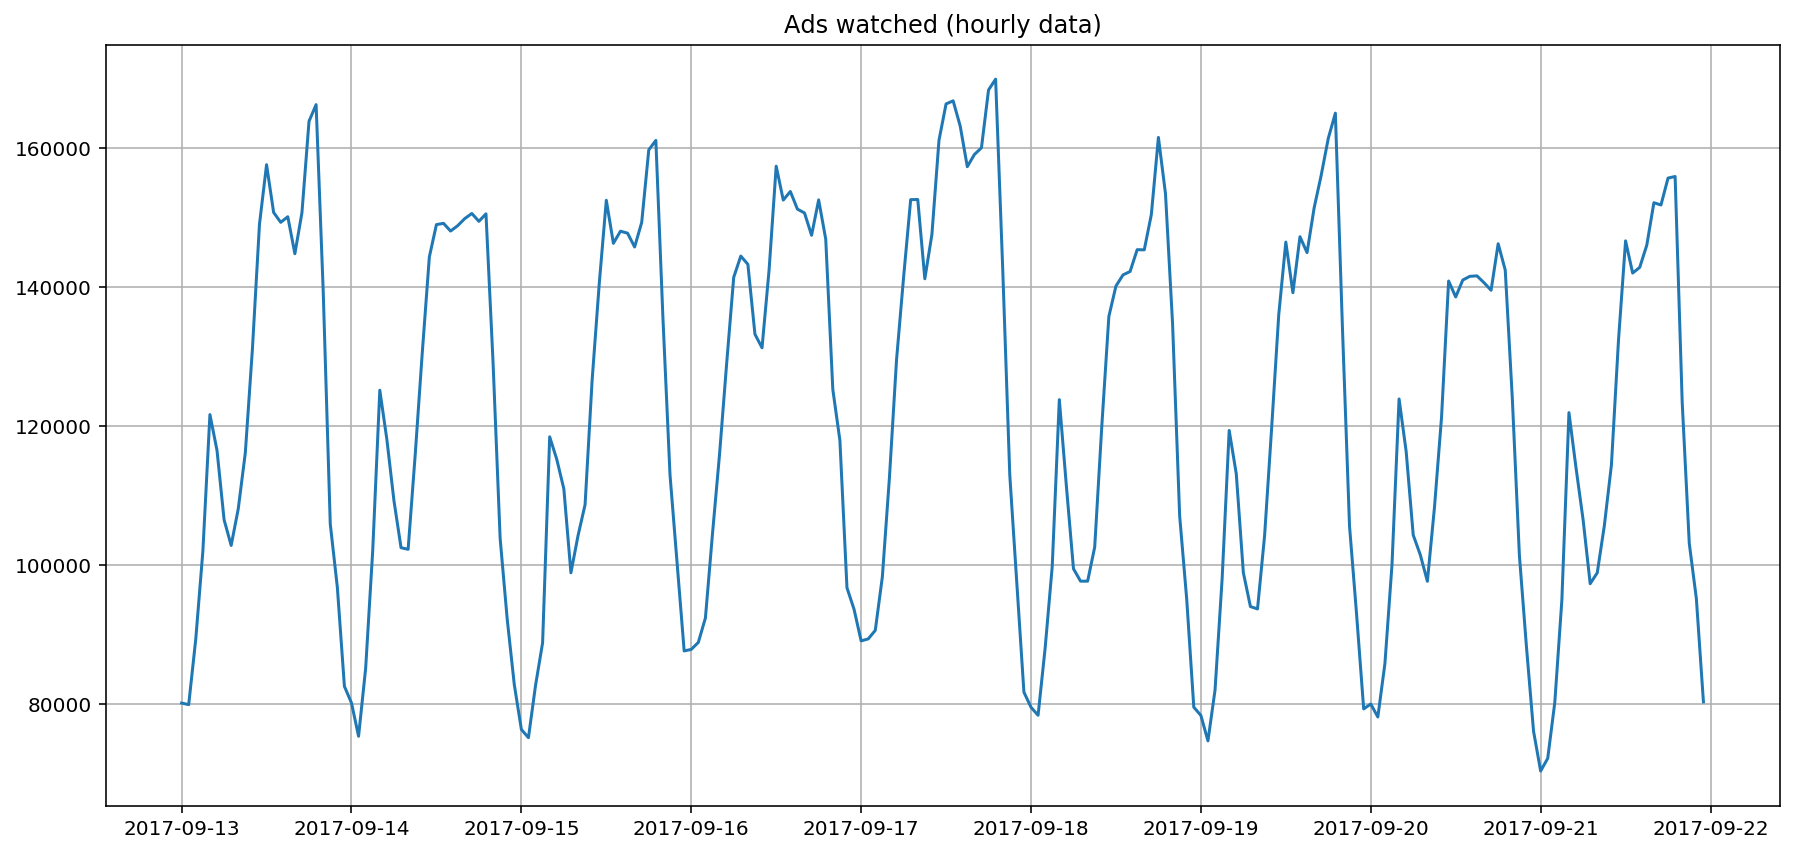

In [7]:
from pandas.plotting import register_matplotlib_converters

# required datetime converter for matplotlib plotting
register_matplotlib_converters()
plt.figure(figsize=(15, 7))
plt.plot(ads[ads_col])
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

Given this 1 dimensional time series data, we will need to do some feature-engineering to make it applicable for a downstream supervised learning method. Including:

- Generating lagged features and window statistics from them.
- We will also add date & time features such as hour of the day, day of the week and a boolean feature indicating whether this is a weekend.

In [8]:
label_col = 'y'
data = pd.DataFrame(ads[ads_col].copy())
data.columns = [label_col]

# add the lag of the target variable from 6 steps back up to 24
for i in range(6, 25):
    data['lag_{}'.format(i)] = data[label_col].shift(i)
    
data['hour'] = data.index.hour
data['weekday'] = data.index.weekday
data['is_weekend'] = data['weekday'].isin([5, 6]).astype(np.int)

data = data.dropna()
data.head()

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,...,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,hour,weekday,is_weekend
Time,,,,,,,,,,,,,,,,,,,,,
2017-09-14 00:00:00,80125,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,157590.0,149020.0,131030.0,...,106495.0,116475.0,121630.0,101930.0,89325.0,79885.0,80115.0,0,3,0
2017-09-14 01:00:00,75335,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,157590.0,149020.0,...,102795.0,106495.0,116475.0,121630.0,101930.0,89325.0,79885.0,1,3,0
2017-09-14 02:00:00,85105,139520.0,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,157590.0,...,108055.0,102795.0,106495.0,116475.0,121630.0,101930.0,89325.0,2,3,0
2017-09-14 03:00:00,102080,105895.0,139520.0,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,...,116125.0,108055.0,102795.0,106495.0,116475.0,121630.0,101930.0,3,3,0
2017-09-14 04:00:00,125135,96780.0,105895.0,139520.0,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,...,131030.0,116125.0,108055.0,102795.0,106495.0,116475.0,121630.0,4,3,0


To generate the window statistics, we'll generate the mean of the lagged features we've created.

In [9]:
lag_cols = [col for col in data.columns if 'lag' in col]
data['rolling_mean'] = data[lag_cols].mean(axis=1)

# extract out the features and labels into separate variables
y = data[label_col].values
data = data.drop(label_col, axis=1)

X = data.values
feature_names = data.columns
print('dimension: ', X.shape)
data.head()

dimension:  (192, 23)


,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,...,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,hour,weekday,is_weekend,rolling_mean
Time,,,,,,,,,,,,,,,,,,,,,
2017-09-14 00:00:00,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,157590.0,149020.0,131030.0,116125.0,...,116475.0,121630.0,101930.0,89325.0,79885.0,80115.0,0,3,0,124731.052632
2017-09-14 01:00:00,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,157590.0,149020.0,131030.0,...,106495.0,116475.0,121630.0,101930.0,89325.0,79885.0,1,3,0,129263.684211
2017-09-14 02:00:00,139520.0,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,157590.0,149020.0,...,102795.0,106495.0,116475.0,121630.0,101930.0,89325.0,2,3,0,132402.368421
2017-09-14 03:00:00,105895.0,139520.0,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,157590.0,...,108055.0,102795.0,106495.0,116475.0,121630.0,101930.0,3,3,0,133274.473684
2017-09-14 04:00:00,96780.0,105895.0,139520.0,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,...,116125.0,108055.0,102795.0,106495.0,116475.0,121630.0,4,3,0,133003.421053


We didn't rely on the `.rolling()` method to generate our rolling mean as we can compute it by taking the mean of the lagged features we've already generated, but the code chunk below also shows how we can generate the same statistics using the `.rolling()` method.

In [10]:
ads[ads_col].shift(6).rolling(window=19).mean().dropna()

Time
2017-09-14 00:00:00    124731.052632
2017-09-14 01:00:00    129263.684211
2017-09-14 02:00:00    132402.368421
2017-09-14 03:00:00    133274.473684
2017-09-14 04:00:00    133003.421053
                           ...      
2017-09-21 19:00:00    106792.368421
2017-09-21 20:00:00    106812.894737
2017-09-21 21:00:00    107974.736842
2017-09-21 22:00:00    110646.315789
2017-09-21 23:00:00    113994.736842
Name: Ads, Length: 192, dtype: float64

Now that we've prepared the data, the next couple of code chunks trains a RandomForest model on the training set (based on a time series train and test split), and evaluates the mean absolute percentage error on the test set and also looks at the feature importance that comes with the RandomForest model.

In [11]:
def timeseries_train_test_split(X, y, test_size):
    """Perform train-test split with respect to time series structure."""
    test_index = int(len(X) * (1 - test_size))
    X_train = X[:test_index]
    X_test = X[test_index:]
    y_train = y[:test_index]
    y_test = y[test_index:]
    return X_train, X_test, y_train, y_test


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def plot_model_results(X, y, test_size=0.3, plot_intervals=False, plot_anomalies=False):
    """
    - Plots modelled vs original values.
    - Prediction intervals (95% confidence interval).
    - Anomalies (points that resides outside the confidence interval).
    """

    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size)

    # we are using random forest here, feel free to swap this out
    # with your favorite regression model
    model = RandomForestRegressor(max_depth=6, n_estimators=50)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)

    plt.figure(figsize=(15, 7))

    x = range(prediction.size)
    plt.plot(x, prediction, label='prediction', linewidth=2.0)
    plt.plot(x, y_test, label='actual', linewidth=2.0)
    if plot_intervals:
        timeseries_cv = TimeSeriesSplit(n_splits=5)
        cv = cross_val_score(model, X_train, y_train, 
                             cv=timeseries_cv, scoring='neg_mean_absolute_error')
        mae = -1 * cv.mean()
        deviation = cv.std()

        # hard-coded to be 95% confidence interval
        scale = 1.96
        margin_error = mae + scale * deviation
        lower = prediction - margin_error
        upper = prediction + margin_error

        fill_alpha = 0.2
        fill_color = '#66C2D7'
        plt.fill_between(x, lower, upper, color=fill_color, alpha=fill_alpha, label='95% CI')      

        if plot_anomalies:
            anomalies = np.array([np.nan] * len(y_test))
            anomalies[y_test < lower] = y_test[y_test < lower]
            anomalies[y_test > upper] = y_test[y_test > upper]
            plt.plot(anomalies, 'o', markersize=10, label='Anomalies')

    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title('Mean absolute percentage error {0:.2f}%'.format(error))
    plt.legend(loc='best')
    plt.tight_layout()
    plt.grid(True)
    
    return model

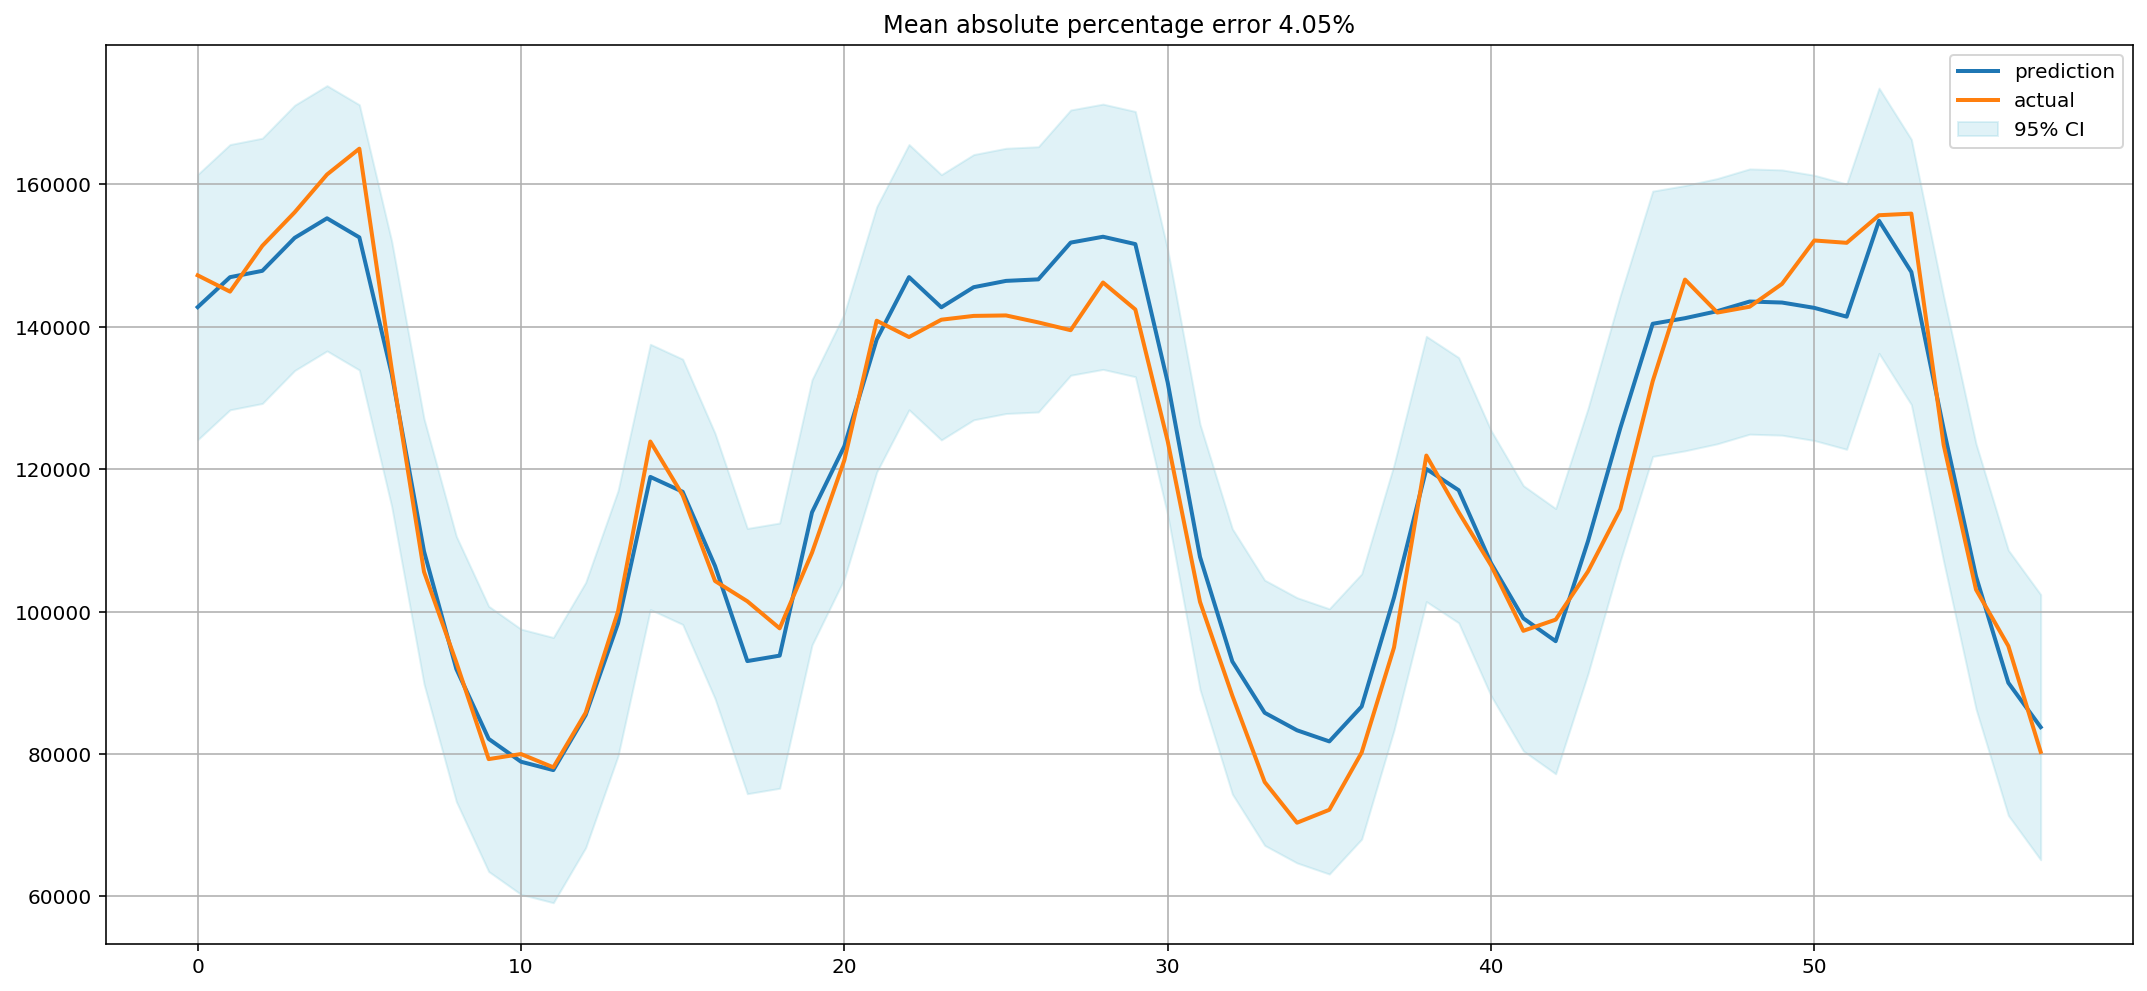

In [12]:
model = plot_model_results(X, y, plot_intervals=True)

In [13]:
def vis_importance(estimator, feature_names, threshold=0.05, filtered_names=None):
    """
    Visualize the relative importance of predictors.

    Parameters
    ----------
    estimator : sklearn-like ensemble tree model
        A tree estimator that contains the attribute
        ``feature_importances_``.

    feature_names : str 1d array or list[str]
        Feature names that corresponds to the
        feature importance.

    threshold : float, default 0.05
        Features that have importance scores lower than this
        threshold will not be presented in the plot, this assumes
        the feature importance sum up to 1.

    filtered_names : str 1d array or list[str], default None
        Feature names that we wish to exclude from the visualization
        regardless of whether they were in the top features or not.
    """
    if not hasattr(estimator, 'feature_importances_'):
        msg = '{} does not have the feature_importances_ attribute'
        raise ValueError(msg.format(estimator.__class__.__name__))

    imp = estimator.feature_importances_
    feature_names = np.array(feature_names)
    if filtered_names is not None:
        keep = ~np.in1d(feature_names, filtered_names, assume_unique=True)
        mask = np.logical_and(imp > threshold, keep)
    else:
        mask = imp > threshold

    importances = imp[mask]
    idx = np.argsort(importances)
    scores = importances[idx]
    names = feature_names[mask]
    names = names[idx]

    y_pos = np.arange(1, len(scores) + 1)
    if hasattr(estimator, 'estimators_'):
        # apart from the mean feature importance, for scikit-learn we can access
        # each individual tree's feature importance and compute the standard deviation
        tree_importances = np.array([tree.feature_importances_
                                     for tree in estimator.estimators_])
        importances_std = np.std(tree_importances[:, mask], axis=0)
        scores_std = importances_std[idx]
        plt.barh(y_pos, scores, align='center', xerr=scores_std)
    else:
        plt.barh(y_pos, scores, align='center')

    plt.yticks(y_pos, names)
    plt.xlabel('Importance')
    plt.title('Feature Importance Plot')

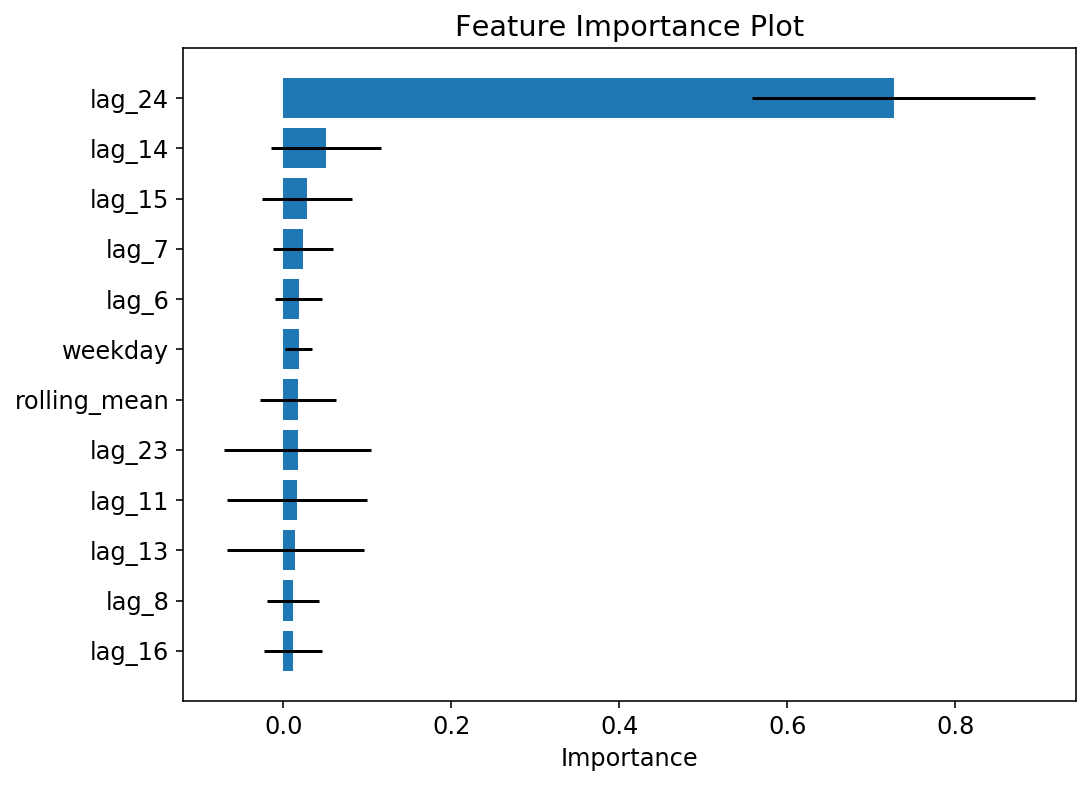

In [14]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

vis_importance(model, feature_names, threshold=0.01)

Looking at the feature importance plot, the most important feature is `lag_24` (each lag is an hour for this dataset), which is not a surprise as yesterday's value is usually a good indicator of what the value is going to be today ...

Hopefully, after reading through this documentation, you have an understanding of how we can re-frame our time series problem into a supervised machine learning problem and perform model training and forecasting using supervised machine learning models.

**Side Note:**

In communicating forecasting result, a useful summary can be something like:

> "If nothing unexpected happens we expect to be within ±x %, but if assumptions a, b, or c perform differently than expected, we might be as much as ±y % off."

- For the ±x % part, notice that in this documentation, we added a confidence interval functionality to our time series forecasting plot. This is where the confidence interval part can come in handy.
- Whereas Monte Carlo simulation can come in handy for the second part of the sentence (if assumptions a, b, or c perform differently ...). For example, when making a supply forecast for a specific event like a product launch, it makes sense to consider scenarios with different sales and production rates as well as any sales bursts arising from media buzz. The scenarios can take the form of low, medium, and high alternatives or Monte Carlo simulations of many possible outcomes from some distribution of impact magnitudes. Note that for the simulation, it helps to understand the drivers that potentially has the most impact so that we know exactly what to simulate.

# Reference

- [Blog: Time Series Forecasting as Supervised Learning](https://machinelearningmastery.com/time-series-forecasting-supervised-learning/)
- [Blog: How to Convert a Time Series to a Supervised Learning Problem in Python](http://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/)
- [Blog: Basic Feature Engineering With Time Series Data in Python](https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/)
- [Blog: What's wrong with my time series? Model validation without a hold-out set
](https://blog.insightdatascience.com/whats-wrong-with-my-time-series-model-validation-without-a-hold-out-set-94151d38cf5b)
- [Jupyter Notebook: Open Machine Learning Course - Time series analysis in Python](http://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic09_time_series/topic9_part1_time_series_python.ipynb)